Using device: cuda


100%|██████████| 170M/170M [00:02<00:00, 65.2MB/s]



Training VGG with SGD...
Epoch 1/10 | Loss: 1.7905 | Acc: 32.24%
Epoch 2/10 | Loss: 1.3513 | Acc: 50.45%
Epoch 3/10 | Loss: 1.1456 | Acc: 58.82%
Epoch 4/10 | Loss: 1.0160 | Acc: 64.11%
Epoch 5/10 | Loss: 0.9173 | Acc: 67.90%
Epoch 6/10 | Loss: 0.8430 | Acc: 71.02%
Epoch 7/10 | Loss: 0.7805 | Acc: 73.28%
Epoch 8/10 | Loss: 0.7274 | Acc: 75.05%
Epoch 9/10 | Loss: 0.6819 | Acc: 76.83%
Epoch 10/10 | Loss: 0.6481 | Acc: 78.04%
Done SGD in 133.9s

Training VGG with Momentum...
Epoch 1/10 | Loss: 1.5365 | Acc: 42.90%
Epoch 2/10 | Loss: 1.0767 | Acc: 62.11%
Epoch 3/10 | Loss: 0.8887 | Acc: 69.42%
Epoch 4/10 | Loss: 0.7726 | Acc: 73.84%
Epoch 5/10 | Loss: 0.6948 | Acc: 76.61%
Epoch 6/10 | Loss: 0.6309 | Acc: 78.72%
Epoch 7/10 | Loss: 0.5866 | Acc: 80.55%
Epoch 8/10 | Loss: 0.5414 | Acc: 81.99%
Epoch 9/10 | Loss: 0.5071 | Acc: 83.13%
Epoch 10/10 | Loss: 0.4844 | Acc: 83.71%
Done Momentum in 139.7s

Training VGG with Nesterov...
Epoch 1/10 | Loss: 1.4658 | Acc: 46.07%
Epoch 2/10 | Loss: 1.0112 |

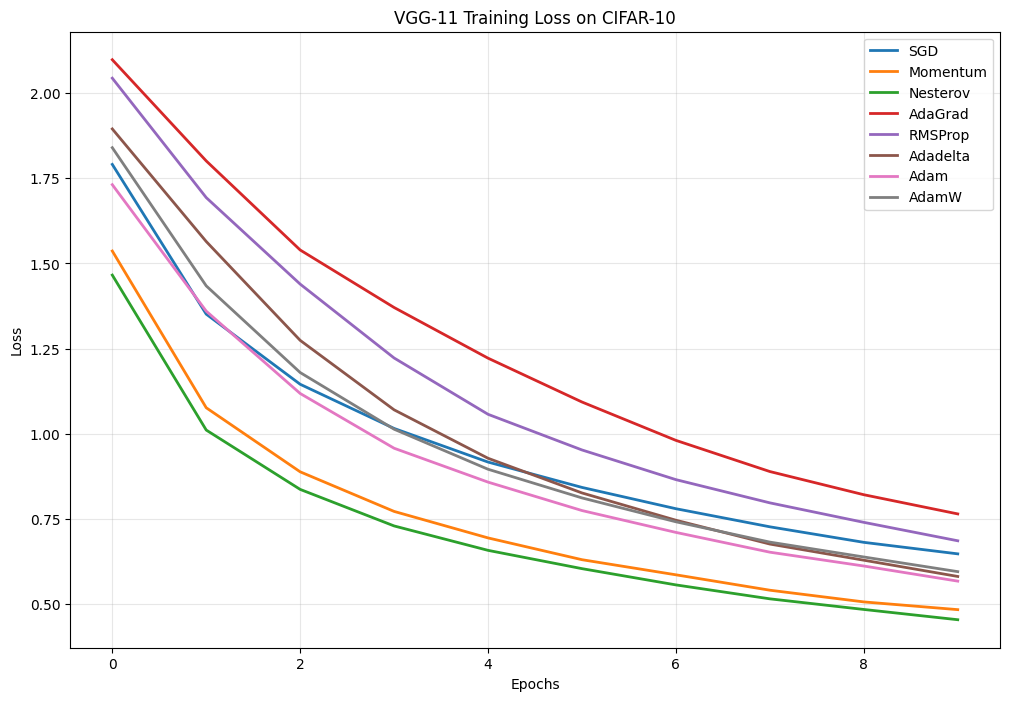

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import numpy as np

# Cấu hình thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==========================================
# 1. CHUẨN BỊ DỮ LIỆU (CIFAR-10)
# ==========================================
# Data Augmentation để giảm Overfitting
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Tải dữ liệu
batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# ==========================================
# 2. MÔ HÌNH VGG-11 (Custom cho CIFAR-10)
# ==========================================
class VGG11_CIFAR(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_CIFAR, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# ==========================================
# 3. HÀM LẤY OPTIMIZER (Đầy đủ)
# ==========================================
def get_optimizer(model, opt_name, lr=0.01):
    if opt_name == 'SGD':
        return optim.SGD(model.parameters(), lr=lr)
    elif opt_name == 'Momentum':
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif opt_name == 'Nesterov':
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
    elif opt_name == 'AdaGrad':
        return optim.Adagrad(model.parameters(), lr=lr)
    elif opt_name == 'RMSProp':
        return optim.RMSprop(model.parameters(), lr=lr/10, alpha=0.99) # RMSProp thường cần lr nhỏ hơn
    elif opt_name == 'Adadelta':
        return optim.Adadelta(model.parameters(), lr=1.0) # Adadelta tự chỉnh learning rate
    elif opt_name == 'Adam':
        return optim.Adam(model.parameters(), lr=lr/10) # Adam thường dùng lr=0.001
    elif opt_name == 'AdamW':
        return optim.AdamW(model.parameters(), lr=lr/10, weight_decay=1e-2)
    else:
        raise ValueError(f"Unknown optimizer: {opt_name}")

# ==========================================
# 4. TRAINING LOOP
# ==========================================
def train_model(opt_name, epochs=15):
    print(f"\nTraining VGG with {opt_name}...")
    model = VGG11_CIFAR().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer(model, opt_name, lr=0.01)
    
    losses = []
    st = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        avg_loss = running_loss / len(trainloader)
        losses.append(avg_loss)
        acc = 100. * correct / total
        
        # Log mỗi epoch
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Acc: {acc:.2f}%")
        
    print(f"Done {opt_name} in {time.time()-st:.1f}s")
    return losses

# ==========================================
# 5. CHẠY THỰC NGHIỆM VÀ VẼ BIỂU ĐỒ
# ==========================================
optimizers_list = ['SGD', 'Momentum', 'Nesterov', 'AdaGrad', 'RMSProp', 'Adadelta', 'Adam', 'AdamW']
results = {}

for opt in optimizers_list:
    results[opt] = train_model(opt, epochs=10) # Demo 10 epochs để tiết kiệm thời gian

# Vẽ biểu đồ
plt.figure(figsize=(12, 8))
for opt, loss in results.items():
    plt.plot(loss, label=opt, linewidth=2)

plt.title("VGG-11 Training Loss on CIFAR-10")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('vgg_cifar10_optimizers.png')
plt.show()